In [1]:
import sys, importlib, time
sys.path.append('../../')

from src.Modules.Utils.Imports import *
from src.Modules.Models.BuildBINNs import BINN
from src.Modules.Utils.ModelWrapper import ModelWrapper
from src.Modules.Utils.Gradient import Gradient

import src.Modules.Utils.PDESolver as PDESolver
import src.Modules.Loaders.DataFormatter as DF

from src.DE_simulation import fickian_diffusion, Diffusion_eqn, simple_pulling_diffusion, simple_adhesion_diffusion
from scipy.integrate import odeint
from scipy.stats import qmc
import numpy.matlib as matlib
from scipy.interpolate import RBFInterpolator
import matplotlib.patches as mpatches

device = torch.device(GetLowestGPU(pick_from=[0,1,2,3]))

# helper functions
def to_torch(x):
    return torch.from_numpy(x).float().to(device)
def to_numpy(x):
    return x.detach().cpu().numpy()



def load_model(binn_name, x, t, save_name):

    # instantiate BINN
    binn = BINN(binn_name,x, t).to(device)
    weight = '_best_val'
    
    # wrap model and load weights
    parameters = binn.parameters()
    model = ModelWrapper(
        model=binn,
        optimizer=None,
        loss=None,
        save_name=save_name)
    
    #model.save_name += '_' + binn.name + weight
    model.save_name += weight
    model.load(model.save_name + '_model', device=device)

    return model, binn


def recover_binn_params(binn):
    # learned diffusion term
    def D(u):
        D = binn.diffusion(to_torch(u)[:, None])
        return to_numpy(D).reshape(-1)

    # learned growth term
    def G(u):
        r = binn.growth(to_torch(u)[:, None])
        return to_numpy(r).reshape(-1)  

    return D, G

def unique_inputs(inputs):
    x = np.unique(inputs[:,0])
    t = np.unique(inputs[:,1])
    return x,t

def data_splitting(inputs,outputs,x,t,perc=0.75):
    
    tmax = np.max(t)

    #train on first 75% of timepoints
    training_index = inputs[:,1] <= perc*tmax
    testing_index  = inputs[:,1] >  perc*tmax
    
    inputs_training = inputs[training_index,:]
    outputs_training = outputs[training_index,:]
    inputs_testing = inputs[testing_index,:]
    outputs_testing = outputs[testing_index,:]

    t_train = np.unique(inputs_training[:,1])
    t_test = np.unique(inputs_testing[:,1])
    
    U_train = outputs_training.reshape((len(x),-1))
    U_test = outputs_testing.reshape((len(x),-1))
    
    return t_train, t_test, U_train, U_test

def DE_sim(x, t, q, IC, Diffusion_function):
    
    sol = odeint(Diffusion_eqn, IC, t, args=(x, q, Diffusion_function))
    sol = sol.T
    
    return sol

def MSE(a,b):
    assert a.shape == b.shape
    return ((a - b)**2).mean()

def plot_DEs_against_data(x, t, U, sol_binn, suptitle=None, filename=None):
    
    assert (len(x) == U.shape[0])
    assert (len(t) == U.shape[1])
    assert (U.shape == sol_binn.shape)
    
    fig, axes = plt.subplots(2,3,figsize=(8,10))
    axes = axes.reshape(-1)

    count = 0
    for i in np.linspace(0,len(t)-1,5,dtype=int):
        axes[count].plot(x[::4],U[::4,i],"o",color="black",markersize=7)
        #axes[count].plot(x,sol[:,i],"-",linewidth=2)
        axes[count].plot(x,sol_binn[:,i],"--",linewidth=2)

        axes[count].set_xlabel("Space (mm)",fontsize=fontsize)
        axes[count].set_ylabel("Density (normalized)",fontsize=fontsize)
        count+=1
        #axes[count].set_xlim([0,20])
        axes[count].set_ylim([0,0.9])
    
    if suptitle is not None:
        plt.suptitle(suptitle)
    if filename is not None:
        if filename[-4:] == ".pdf":
            plt.savefig(filename)
        else:
            plt.savefig(filename+".pdf")
            
path = '../../data/'
filename_header = "simple_adhesion_mean_25"

### BINN model information
save_folder = "../../Weights/"
model_name = 'DMLP'
weight = '_best_val'
pde_weight = 1e4

Pp = 0.0
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

def BINN_Diffusion_mesh_generate_fixed_Pm(u_mesh,Padhs,Pm=1.0):
    
    D_mesh = []

    #Create mesh of D^{MLP} from computed Padh, Pm values
    for Padh in Padhs:

        file_name = f'{filename_header}_Pm_{Pm}_Pp_{Pp}_Padh_{Padh}'    

        binn_name  = f"{model_name}"
        save_name =  f"BINN_training_{binn_name}_{file_name}_pde_weight_{pde_weight}"
        model,binn = load_model(binn_name=binn_name,save_name=save_folder + save_name,x=1.0,t=1.0)
        
        # evaluate parameter networks
        D_mesh_tmp = to_numpy(binn.diffusion(to_torch(u_mesh)[:, None]))
        D_mesh.append(np.squeeze(D_mesh_tmp))
    
    return np.array(D_mesh).T

def BINN_Diffusion_mesh_generate(u_mesh,Padhs,Pms):
    
    D_mesh = []

    #Create mesh of D^{MLP} from computed Padh, Pm values
    for Pm in Pms:
        
        D_mesh_Padh_u = []
        
        for Padh in Padhs:

            file_name = f'{filename_header}_Pm_{Pm}_Pp_{Pp}_Padh_{Padh}'    

            binn_name  = f"{model_name}"
            save_name =  f"BINN_training_{binn_name}_{file_name}_pde_weight_{pde_weight}"
            model,binn = load_model(binn_name=binn_name,save_name=save_folder + save_name,x=1.0,t=1.0)
            
            # evaluate parameter networks
            D_mesh_Padh_u_tmp = to_numpy(binn.diffusion(to_torch(u_mesh)[:, None]))
            D_mesh_Padh_u.append(np.squeeze(D_mesh_Padh_u_tmp))
        
        D_mesh.append(D_mesh_Padh_u)
    
    return np.array(D_mesh).T 

def simulate_interpolant_PDE(Padh,Pm,f):

    def interpolated_diffusion(u):
        U, PADH, PM = np.meshgrid( u , Padh, Pm, indexing = "ij")
        shape = U.shape
        try:
            new_points = np.array(list(zip(U.reshape(-1), 
                                           PADH.reshape(-1) )))
            D_mesh_new = f(new_points).reshape(shape)[:,0,0]
            D_mesh_new[D_mesh_new < 0] = 0
            return D_mesh_new
        except:
            new_points = np.array(list(zip(U.reshape(-1), 
                                           PADH.reshape(-1),
                                           PM.reshape(-1)   )))
            D_mesh_new = f(new_points).reshape(shape)[:,0,0]
            D_mesh_new[D_mesh_new < 0] = 0
            return D_mesh_new

    file_name = f'{filename_header}_Pm_{Pm}_Pp_{Pp}_Padh_{Padh}' 
    #try:
    #    inputs, outputs, shape  = DF.load_ABM_data(path+file_name+"_perc_0.75.npy",plot=False)
    #except:
    inputs, outputs, shape  = DF.load_ABM_data(path+file_name+".npy",plot=False)

    x,t = unique_inputs(inputs)

    U = outputs.reshape((len(x),-1))
    IC = U[:,0]

    t0 = time.time()
    sol = DE_sim(x, 
                 t, 
                 [], 
                 IC, 
                 Diffusion_function = interpolated_diffusion)
        
    tf = time.time()-t0
    
    return x, t, sol, U, tf
    
def plot_sol_data(x,t,sol,U):
    
    fig, axes = plt.subplots(1,3,figsize=(18,6))

    count = 0
    for i in [33, 66, 99]:
        axes[count].plot(x,sol[:,i],"--",linewidth=5, c = colors[2], label = "Interpolated BINN DE model")
        axes[count].plot(x[::4],U[::4,i],"o",color="black",markersize=8,label="Data")

        axes[count].set_xlabel("Space ($x$)",fontsize=fontsize)
        axes[count].set_ylabel("Density",fontsize=fontsize)
        axes[count].set_title(f"t = {round(t[i],1)}",fontsize=fontsize)
        count+=1
        
    return fig, axes

    
def MSE_computation_Padh(Padh, Pm, f):
    
    x, t, sol, U, tf = simulate_interpolant_PDE(Padh,Pm,f)

    t_max = np.max(t)
    t_perc = 0.75
    
    U_train = U[:,t<=t_perc*t_max]
    U_test  = U[:,t >t_perc*t_max]
    
    sol_train = sol[:,t<=t_perc*t_max]
    sol_test  = sol[:,t >t_perc*t_max]
    
    
    MSE_train =  MSE(sol_train, U_train)
    MSE_test = MSE(sol_test, U_test)
    
    return MSE_train, MSE_test

Device set to cpu


/home/hpc/nardinij/.local/lib/python3.9/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


## Interpolation with RBF

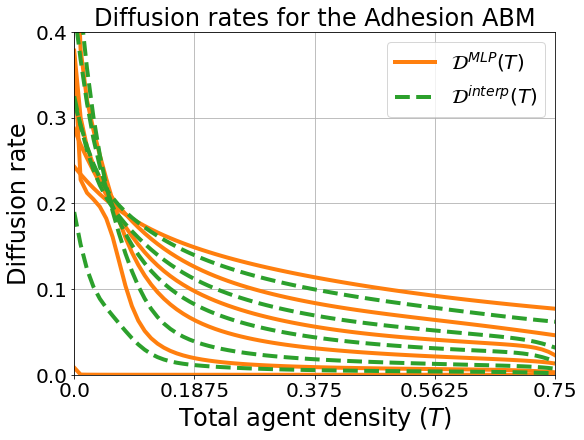

In [3]:
from scipy.interpolate import RBFInterpolator

Pm = 1.0 #0.1, 0.5, 1.0
Padhs = np.array([.5, .6, .7, .8, .9, 1.0])
Padhs_new = np.array([.55, .65, .75, .85, .95])
Pm_new = 1.0

u_mesh = np.linspace(0, 1, 101)
U_mesh, Padh_mesh = np.meshgrid(u_mesh , Padhs, indexing = "ij")
U_mesh_new, Padh_mesh_new = np.meshgrid( u_mesh , Padhs_new, indexing = "ij")

D_mesh = BINN_Diffusion_mesh_generate_fixed_Pm(u_mesh, Padhs, Pm)

sampled_points = np.array(list(zip(U_mesh.reshape(-1), 
                                 Padh_mesh.reshape(-1) )))
shape = U_mesh_new.shape
new_points = np.array(list(zip(U_mesh_new.reshape(-1), 
                                 Padh_mesh_new.reshape(-1) )))

f = RBFInterpolator(sampled_points, D_mesh.reshape(-1))
D_mesh_new = f(new_points).reshape(shape)

data = {}
data['f'] = f
np.save("../../results/PDE_sims/adhesion_interpolant_Pm_fixed.npy",data)

#initialize plot
fontsize=24

fig, ax = plt.subplots(1,1,figsize=(8,6),layout="constrained")

prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

count = 0
for Padh in Padhs:
    label = "$\mathcal{D}^{MLP}(T)$" if count==0 else ""
    ax.plot(u_mesh, D_mesh[:,count], color=colors[1],linewidth=4, label=label)
    count+=1

count = 0
for Padh in Padhs_new:
    label = "$\mathcal{D}^{interp}(T)$" if count==0 else ""    
    ax.plot(u_mesh, D_mesh_new[:,count], "--",linewidth=4, color = colors[2], label=label)
    count+=1

ax.set_xlim([0,0.75])
ax.set_ylim([0,0.4])

ax.set_xlabel("Total agent density ($T$)",fontsize=fontsize)
ax.set_ylabel("Diffusion rate",fontsize=fontsize)
ax.set_title("Diffusion rates for the Adhesion ABM",fontsize=fontsize)

plt.xticks([0, 0.375/2, 0.375, 0.375*3/2,  0.75], labels = np.round([0, 0.375/2, 0.375, 0.375*3/2,  0.75],4), fontsize=20)
plt.yticks([0, 0.1, 0.2, 0.3, 0.4],fontsize=20)


plt.grid()
plt.legend(fontsize=20)

plt.savefig(f"../../results/figures/Adhesion_Interpolated_diffusion_rates_Pm_fixed.png",format="png") 

In [13]:
#prop_cycle = plt.rcParams['axes.prop_cycle']
#colors = prop_cycle.by_key()['color']

'''interpolated_sol_MSEs_train_new = []
interpolated_sol_MSEs_test_new = []
for Padh in Padhs_new:
    
    print(Padh)
    
    MSE_train, MSE_test = MSE_computation_Padh(Padh, Pm, f)

    interpolated_sol_MSEs_train_new.append(MSE_train)
    interpolated_sol_MSEs_test_new.append(MSE_test)

    #plot_DEs_against_data(x, t, U, sol,
    #                         suptitle = f"Interpolated DE Solution: $P_m$ = {Pm}, " + "$P_{adh} = $" + f"{Padh}\n MSE = {interpolated_sol_MSE}",
    #                         filename = f"../../results/figures/DE_interpolate_sol_Pm_{Pm}_Padh_{Padh}.pdf")    
interpolated_sol_MSEs_train_new = np.array(interpolated_sol_MSEs_train_new)
interpolated_sol_MSEs_test_new = np.array(interpolated_sol_MSEs_test_new)

interpolated_sol_MSEs_train_old = []
interpolated_sol_MSEs_test_old = []
for Padh in Padhs:
    
    print(Padh)
    
    MSE_train, MSE_test = MSE_computation_Padh(Padh, Pm, f)

    interpolated_sol_MSEs_train_old.append(MSE_train)
    interpolated_sol_MSEs_test_old.append(MSE_test)

interpolated_sol_MSEs_train_old = np.array(interpolated_sol_MSEs_train_old)
interpolated_sol_MSEs_test_old = np.array(interpolated_sol_MSEs_test_old)
'''
fontsize=24
plt.figure(figsize=(8,6),layout="constrained")

MSE_trains = np.zeros((len(interpolated_sol_MSEs_train_new)+len(interpolated_sol_MSEs_train_old)))
MSE_tests = np.zeros(MSE_trains.shape)
Padhs_all = np.zeros(MSE_trains.shape)
MSE_trains[::2] = interpolated_sol_MSEs_train_old
MSE_trains[1::2] = interpolated_sol_MSEs_train_new
MSE_tests[::2] = interpolated_sol_MSEs_test_old
MSE_tests[1::2] = interpolated_sol_MSEs_test_new
Padhs_all[::2] = Padhs
Padhs_all[1::2] = Padhs_new
#plt.semilogy(Padhs_all,MSE_trains,"k-")
#plt.semilogy(Padhs_all,MSE_tests,"k--")
#plt.semilogy(Padhs,interpolated_sol_MSEs_train_old,".",c=colors[1],markersize=15)
#plt.semilogy(Padhs,interpolated_sol_MSEs_test_old,".",c=colors[1],markersize=15)
#plt.semilogy(Padhs_new,interpolated_sol_MSEs_train_new,"x",c=colors[2],markersize=20)
#plt.semilogy(Padhs_new,interpolated_sol_MSEs_test_new,"x",c=colors[2],markersize=20)

N = len(interpolated_sol_MSEs_train_old)
plt.bar(np.arange(0,2*N,2)-.167, interpolated_sol_MSEs_train_old,color = colors[1], width = 0.33, log = True, edgecolor="k", label = "Binn-guided training MSE")
plt.bar(np.arange(0,2*N,2)+.167, interpolated_sol_MSEs_test_old,color = colors[1], width = 0.33, log = True, edgecolor="k", hatch=".", label = "Binn-guided testing MSE")
#plt.bar(np.arange(N)+.33, interpolated_sol_MSEs_test_new[MSE_sort_index],color = colors[2], width = 0.33, log = True, label = "Testing data", hatch = ".", edgecolor="k")
plt.bar(np.arange(1,2*N-1,2)-.167, interpolated_sol_MSEs_train_new,color = colors[2], width = 0.33, log = True, edgecolor="k", label = "Interpolated training MSE")
plt.bar(np.arange(1,2*N-1,2)+.167, interpolated_sol_MSEs_test_new,color = colors[2], width = 0.33, log = True, edgecolor="k", hatch=".", label = "Interpolated testing MSE")

xlabels = [f"{round(.5+i*.05,2)}" for i in np.arange(11)]
plt.xticks(np.arange(11), labels = xlabels, rotation = 0, fontsize=15)
plt.yticks([1e-4, 2e-4, 6e-4],labels = ["$10^{-4}$", r"$2\times10^{-4}$", r"$6\times10^{-4}$"],fontsize=15, rotation=50)


plt.xlabel("$p_{adh}$",fontsize=fontsize)
plt.ylabel("Mean-squared Error (MSE)",fontsize=fontsize)
plt.title("Error in predicting the Adhesion ABM",fontsize=fontsize)
plt.legend(fontsize=20)
plt.grid(axis="y")
plt.ylim([5e-5,6.3e-4])
plt.savefig(f"../../results/figures/Adhesion_Interpolation_error_fixed_Pm.png",format="png")

NameError: name 'interpolated_sol_MSEs_train_old' is not defined

<Figure size 576x432 with 0 Axes>

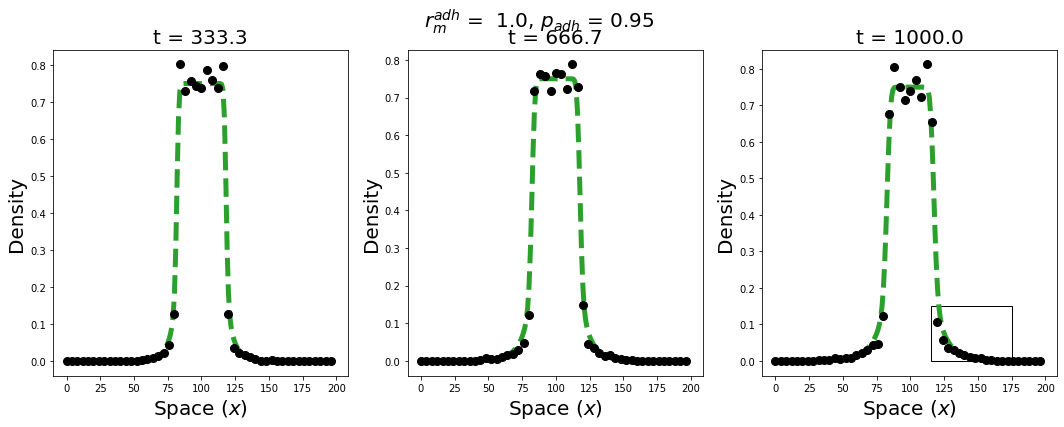

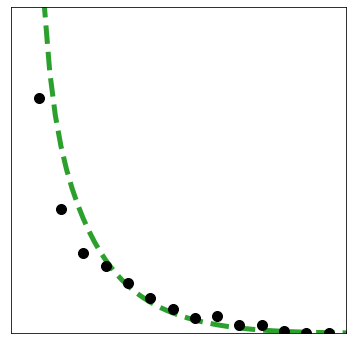

In [50]:
Padh = 0.95
Pm = 1.0

x, t, sol, U, tf = simulate_interpolant_PDE(Padh,Pm,f)

fig, axes = plot_sol_data(x,t,sol,U)

if Padh == 0.85:
    rect=mpatches.Rectangle((125,0),50,.1, 
                        fill = False,
                        color = "black",
                        linewidth = 1)
    plt.gca().add_patch(rect)
if Padh == 0.95:
    rect=mpatches.Rectangle((115,0),60,.15, 
                        fill = False,
                        color = "black",
                        linewidth = 1)
    plt.gca().add_patch(rect)

    #axes[2].set_xlim([115,175])
    #axes[2].set_ylim([0,0.15])
    
plt.suptitle("$r_m^{adh}$ =  " + f"{Pm}, " +"$p_{adh}$" + f" = {Padh}"
             ,fontsize=fontsize)    
plt.savefig(f"../../results/figures/Adhesion_Interpolation_simulation_Padh_{Padh}_fixed_Pm.png",format="png")

fig, axes = plt.subplots(1,1,figsize=(6,6))

count = 0
i = 99
axes.plot(x,sol[:,i],"--",linewidth=5, c = colors[2], label = "Interpolated BINN DE model")
axes.plot(x[::4],U[::4,i],"o",color="black",markersize=10,label="Data")
axes.set_xticks([])
axes.set_yticks([])
axes.set_xlim([115,175])
axes.set_ylim([0,0.15])
plt.savefig(f"../../results/figures/Adhesion_Interpolation_simulation_Padh_{Padh}_fixed_Pm_ZOOM.png",format="png")

## Interpolation along Padh and Pm

0.145 0.825
0.505 0.575
0.415 0.725
0.865 0.525
0.955 0.625
0.235 0.775
0.685 0.675
0.325 0.875
0.775 0.925
0.595 0.975


<Figure size 576x432 with 0 Axes>

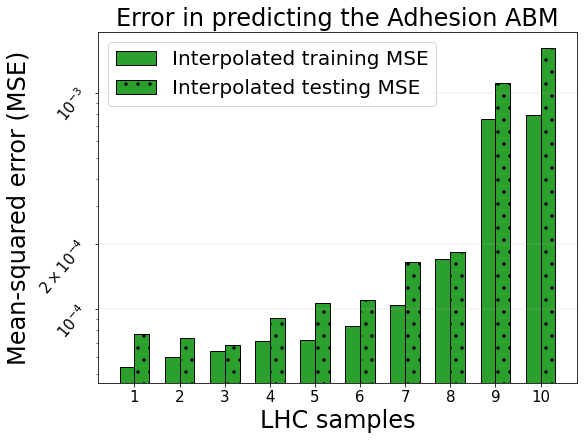

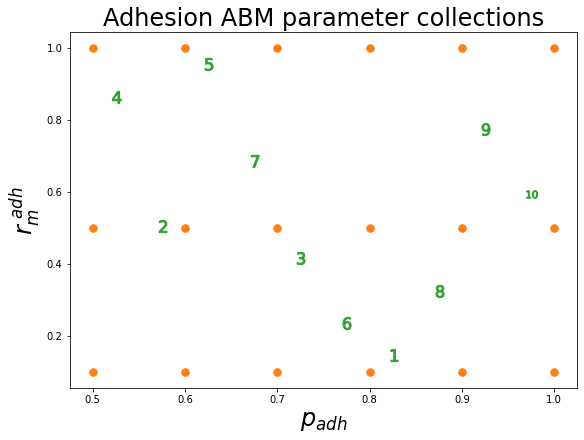

In [3]:
fontsize=24
#locate previously-computed points
u_mesh = np.linspace(0, 1, 101)
Pms = np.array([0.1, 0.5, 1.0])
Padhs = np.array([.5, .6, .7, .8, .9, 1.0])
U_mesh, Padh_mesh, Pm_mesh = np.meshgrid( u_mesh , Padhs, Pms, indexing="ij")
D_mesh = BINN_Diffusion_mesh_generate(u_mesh, Padhs, Pms)

#RBF interpolator
sampled_points =  np.array(list(zip(U_mesh.reshape(-1), 
                                        Padh_mesh.reshape(-1),
                                        Pm_mesh.reshape(-1))  ))
f = RBFInterpolator(sampled_points, D_mesh.reshape(-1), kernel="linear")

data = {}
data['f'] = f
np.save("../../results/PDE_sims/adhesion_interpolant.npy",data)


### Latin Hypercube sampling for new points
sampler = qmc.LatinHypercube(d=2,centered=True,seed=1)
Pm_Padh_sample = sampler.random(n=10)
l_bounds = [0.1, 0.5]
u_bounds = [1.0, 1.0]
Pm_Padh_sample = np.round(qmc.scale(Pm_Padh_sample, l_bounds, u_bounds),4)
Pms_new = Pm_Padh_sample[:,0]
Padhs_new = Pm_Padh_sample[:,1]

interpolated_sol_MSEs_train_new = []
interpolated_sol_MSEs_test_new = []

for Padh, Pm in zip(Padhs_new, Pms_new):
    
    MSE_train, MSE_test = MSE_computation_Padh(Padh, Pm, f)

    interpolated_sol_MSEs_train_new.append(MSE_train)
    interpolated_sol_MSEs_test_new.append(MSE_test)

interpolated_sol_MSEs_train_new = np.array(interpolated_sol_MSEs_train_new)
interpolated_sol_MSEs_test_new = np.array(interpolated_sol_MSEs_test_new)

MSE_sort_index = np.argsort(interpolated_sol_MSEs_train_new)

'''plt.figure(figsize=(8,6))

plt.semilogy(np.arange(1,11),
             interpolated_sol_MSEs_train_new[MSE_sort_index],
             "k-")
plt.semilogy(np.arange(1,11),
             interpolated_sol_MSEs_test_new[MSE_sort_index],
             "k--")
plt.semilogy(np.arange(1,11),
             interpolated_sol_MSEs_train_new[MSE_sort_index],
             "x",c=colors[2], markersize=20)
plt.semilogy(np.arange(1,11),
             interpolated_sol_MSEs_test_new[MSE_sort_index],
             "x",c=colors[2], markersize=20)

fontsize=24
plt.xlabel("LHC sample (ordered by training MSE)",fontsize=fontsize)
plt.ylabel("Mean-squared Error (MSE)",fontsize=fontsize)
plt.title("Error analysis for interpolated BINN PDE models",fontsize=fontsize)
plt.yticks([1e-4,2e-4,1e-3])
plt.grid()
plt.savefig(f"../../results/figures/Adhesion_Interpolation_error_Padh_and_Pm.png",format="png")'''

plt.figure(figsize=(8,6), layout='constrained')
MSE_sort_index = np.argsort(interpolated_sol_MSEs_train_new)

prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

plt.figure(figsize=(8,6),layout="constrained")
N = len(interpolated_sol_MSEs_train_new)
plt.bar(np.arange(N), interpolated_sol_MSEs_train_new[MSE_sort_index],color = colors[2], width = 0.33, log = True, label = "Interpolated training MSE", edgecolor="k")
plt.bar(np.arange(N)+.33, interpolated_sol_MSEs_test_new[MSE_sort_index],color = colors[2], width = 0.33, log = True, label = "Interpolated testing MSE", hatch = ".", edgecolor="k")

xlabels = [f"{i}" for i in np.arange(1,N+1)]
plt.xticks(np.arange(N)+.167, labels = xlabels, rotation = 0, fontsize=15)
plt.yticks([1e-4, 2e-4, 1e-3],labels = ["$10^{-4}$", r"$2\times10^{-4}$", "$10^{-3}$"],fontsize=15, rotation=50)

plt.grid(axis="y", linewidth=0.25)

plt.xlabel("LHC samples", fontsize=fontsize)
plt.ylabel("Mean-squared error (MSE)", fontsize=fontsize)
plt.title("Error in predicting the Adhesion ABM", fontsize=fontsize)

plt.legend(fontsize=20)
plt.savefig("../../results/figures/adhesion_interpolation.pdf",format="pdf")


MSE_sort_index = np.argsort(interpolated_sol_MSEs_train_new)

plt.figure(figsize=(8,6),layout="constrained")
Pms = [0.1, 0.5, 1.0]
Padhs = [.5,.6,.7,.8,.9,1.0]
count = 0
for Pm in Pms:
    for Padh in Padhs:
        if count == 0:
            label = "$\mathcal{P}^{prior}$"
        else:
            label = ""
        plt.plot(Padh,Pm,".",c=colors[1],markersize=15,label=label)
        count+=1

count = 0
for ii in MSE_sort_index:
    if count == 0:
            label = "$\mathcal{P}^{new}$"
    else:
        label = ""
    Pm,Padh = Pm_Padh_sample[ii]
    print(Pm,Padh)
    #plt.plot(Padh,Pm,colors[2],marker=f"${count+1}$",markersize=10,label=label)
    plt.scatter(Padh,Pm,c=colors[2],marker=f"${count+1}$",s=150,label=label)
    count+=1

plt.xlabel("$p_{adh}$",fontsize=fontsize)
plt.ylabel("$r_m^{\ adh}$",fontsize=fontsize)
#plt.legend(fontsize=fontsize)
plt.title("Adhesion ABM parameter collections",fontsize=fontsize)
plt.savefig(f"../../results/figures/Adhesion_sample_locations_Padh_and_Pm.png",format="png")

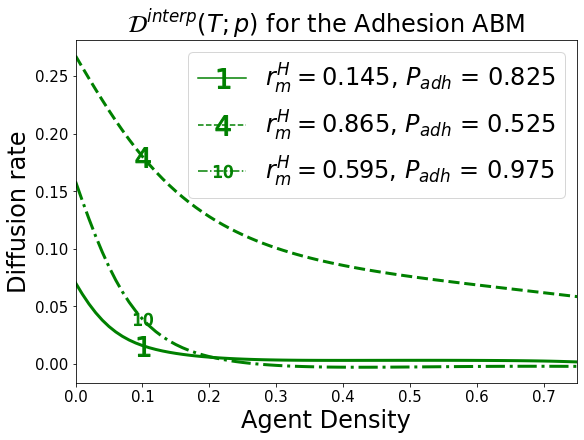

In [43]:
fontsize=24
plt.figure(figsize=(8,6),layout="constrained")
count = 0
lines = ["-","--","-."]
for i in [0, 3, 9]:
    index = MSE_sort_index[i]
    Pm,Padh = Pms_new[index], Padhs_new[index]
    u = np.linspace(0,1,101)

    param_mesh = matlib.repmat((Padh,Pm),len(u),1)
    sampled_points_mesh = np.hstack([u[:,None], param_mesh])
    D_mesh_new = f(sampled_points_mesh)

    padh_str = ""
    plt.plot(u,D_mesh_new,color="g",linestyle=lines[count], linewidth=3, markersize=15)
    plt.plot(u[10],D_mesh_new[10],color="g",marker=f"${i+1}$",linestyle=lines[count],markersize=20,label=f"$r_m^H = ${Pm}, "+"$P_{adh}$ = "+f"{Padh}")
    count+=1
    
plt.xlim([0,0.75])
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(fontsize=fontsize)
plt.xlabel("Agent Density",fontsize=fontsize)
plt.ylabel("Diffusion rate",fontsize=fontsize)
plt.title(r"$\mathcal{D}^{interp}(T; p)$ for the Adhesion ABM",fontsize=fontsize)

plt.savefig("../../results/figures/adhesion_interpolation_diffusion_rates.pdf",format="pdf")

0.975 0.595


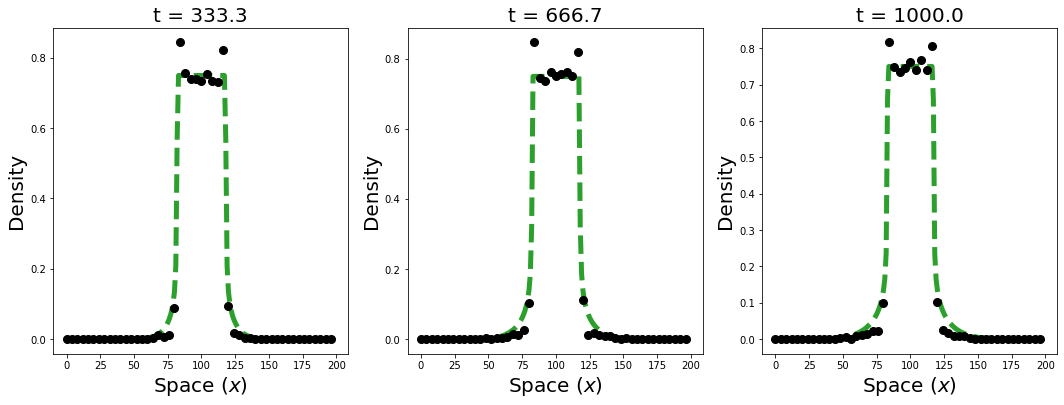

In [15]:
#look at worst simulation
Padh = Padhs_new[MSE_sort_index[-1]]
Pm = Pms_new[MSE_sort_index[-1]]

print(Padh, Pm)

x, t, sol, U, tf = simulate_interpolant_PDE(Padh,Pm,f)

fig, axes = plot_sol_data(x,t,sol,U)

plt.savefig(f"../../results/figures/Adhesion_Interpolation_simulation_Padh_{Padh}_Pm_{Pm}.png",format="png")

## Make table of samples

In [12]:
print("    \centering")
print(r"    \begin{tabular}{|c|c|}")
print("    \hline")
print("    Sample &   \\Pm = $(r_m^{adh},\ {p_{adh}})^T$ \\\\ \\hline")
for i in np.arange(len(MSE_sort_index)):
    index = MSE_sort_index[i]
    Pm,Padh = Pms_new[index], Padhs_new[index]
    print(f"    {i+1} &   ({Pm}, {Padh})$^T$ \\\\ \\hline")
print("    \end{tabular}")    

    \centering
    \begin{tabular}{|c|c|}
    \hline
    Sample &   \Pm = $(r_m^{adh},\ {p_{adh}})^T$ \\ \hline
    1 &   (0.145, 0.825)$^T$ \\ \hline
    2 &   (0.505, 0.575)$^T$ \\ \hline
    3 &   (0.415, 0.725)$^T$ \\ \hline
    4 &   (0.865, 0.525)$^T$ \\ \hline
    5 &   (0.955, 0.625)$^T$ \\ \hline
    6 &   (0.235, 0.775)$^T$ \\ \hline
    7 &   (0.685, 0.675)$^T$ \\ \hline
    8 &   (0.325, 0.875)$^T$ \\ \hline
    9 &   (0.775, 0.925)$^T$ \\ \hline
    10 &   (0.595, 0.975)$^T$ \\ \hline
    \end{tabular}
